# Timestamp Noise
or - softenning the margins

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2 

In [157]:
import re
from tqdm import tqdm

In [88]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds

In [3]:
data = pd.read_parquet("../Data/10K_HH.parquet")

In [4]:
data = data[data["maid"]==7]

In [5]:
data = data[data["time"] >= pd.to_datetime("2022-12-01")]

In [6]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.osversion.str.match(pattern)]

In [7]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.browserversion.str.match(pattern)]

Sample tow cookies with the same ua

In [36]:
constants = ['brand','model','os', 'osversion', 'browser', 'advertisedbrowser', 'browserversion']

In [37]:
data_groups = data.groupby(constants)['iiqid'].nunique()

In [71]:
sample_specs = data_groups[data_groups > 1].sample().index.to_list()[0]

In [72]:
sample_data = data[data[constants].eq(sample_specs).all(axis=1)].copy()
sample_data.sort_values(by='time', inplace=True)

In [83]:
found = False
limit = 1000
while not found and limit > 0:
    sample_specs = data_groups[data_groups > 1].sample().index.to_list()[0]
    sample_data = data[data[constants].eq(sample_specs).all(axis=1)]
    if sample_data['iiqid'].value_counts()[:2].min() > 10:
        two_frequent = sample_data.loc[sample_data['iiqid'].isin(sample_data['iiqid'].value_counts()[:2].index)].copy()
        two_frequent.sort_values(by='time', inplace=True)
        found = True
    limit -= 1

<Axes: xlabel='time', ylabel='iiqid'>

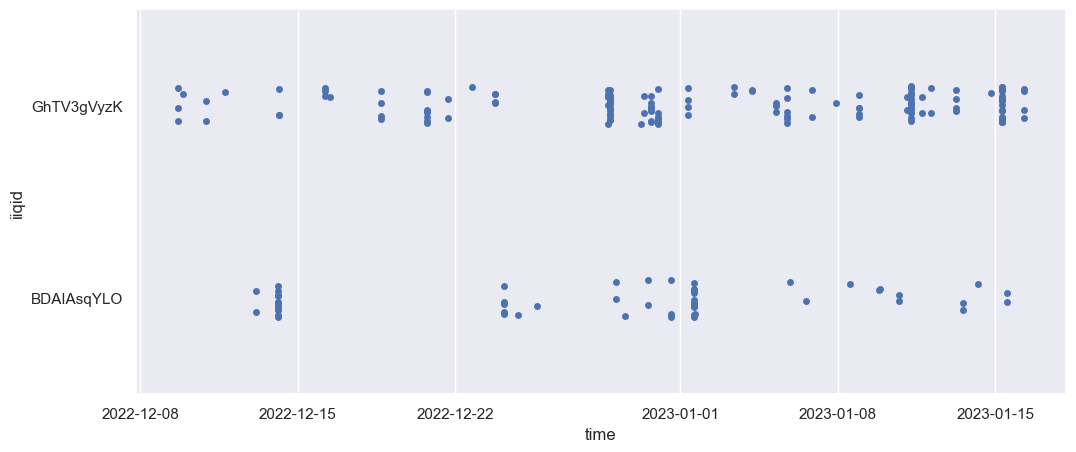

In [95]:
# sns.stripplot(data=two_frequent, x='time', y='browserversion', hue='iiqid')
sns.stripplot(data=two_frequent, x='time', y='iiqid')

In [90]:
serialize_id = {iiq: i for i, iiq in enumerate(two_frequent['iiqid'].unique())}

In [91]:
two_frequent['iiqid_num'] = two_frequent['iiqid'].apply(lambda x: serialize_id[x])

In [105]:
s, inds = lnds(two_frequent['iiqid_num'].values)
not_inds = [i for i in range(len(two_frequent)) if i not in inds]

<Axes: xlabel='time', ylabel='iiqid'>

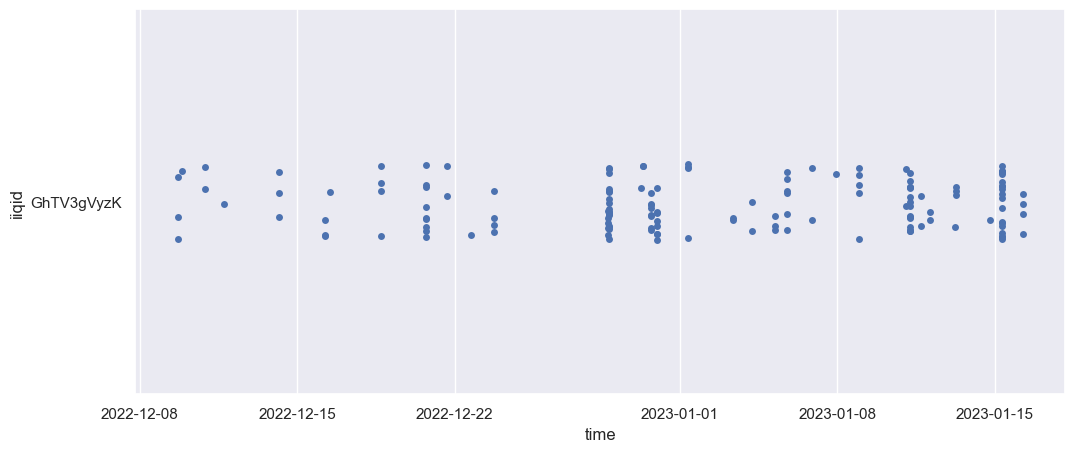

In [104]:
sns.stripplot(data=two_frequent.iloc[inds], x='time', y='iiqid')

[Text(0, 0, 'GhTV3gVyzK'), Text(0, 1, 'BDAIAsqYLO')]

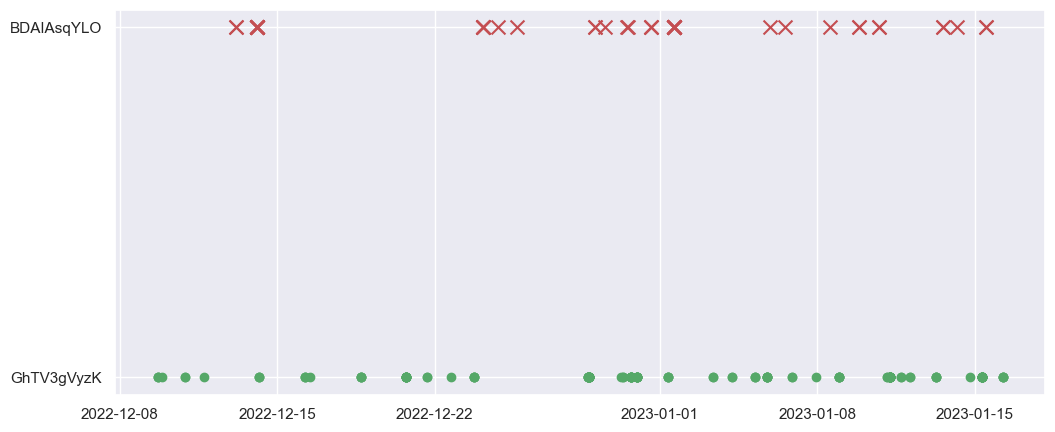

In [111]:
fig, ax = plt.subplots()
ax.scatter(two_frequent['time'].iloc[not_inds], 
           [v for i, v in enumerate(two_frequent['iiqid_num'].values) if i in not_inds], s=100, c='r', marker='x')
ax.scatter(two_frequent.time.iloc[inds], s, c='g', marker='o')
# ax.set_title(f"Cookie's iiqid: {one_cookie_id}")
# ax.set_yticks(range(min(two_frequent['iiqid_num'].values), max(two_frequent['iiqid_num'].values)+1))
ax.set_yticks([0,1])
ax.set_yticklabels(two_frequent['iiqid'].unique())

In [113]:
len(s)/ len(two_frequent)

0.7268292682926829

## Randomize Trial

### Random Pairs

In [136]:
from itertools import combinations
import random

In [132]:
houses = data['hh_id'].unique()
pairs = list(combinations(houses, 2))

In [137]:
sample_size = 1000
random_pairs = random.sample(pairs, sample_size)

In [146]:
pair = random_pairs[0]
pair_data = data[data['hh_id'].isin(pair)].copy()
pair_data.sort_values(by='time', inplace=True)
random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}

In [150]:
serialize_id

{'2h9dQiCeUt': 0, 'yXzjL8h3KQ': 1}

In [153]:
pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])

5156556    True
5156555    True
6302737    True
6302736    True
6302735    True
           ... 
5156334    True
5156333    True
5156332    True
6302598    True
6302597    True
Name: iiqid, Length: 391, dtype: bool

In [212]:
noise_of_pairs = []
for pair in tqdm(random_pairs):
    pair_data = data[data['hh_id'].isin(pair)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
    random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
    pair_data = pair_data[pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])]
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    noise_of_pairs.append(len(s) / len(pair_data))

100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.06it/s]


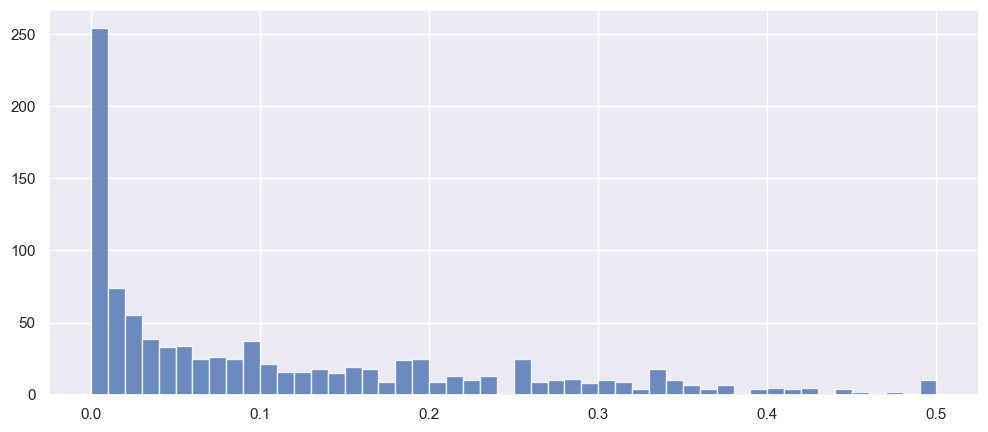

In [214]:
plt.hist([1-i for i in noise_of_pairs], alpha=0.8, bins=50);

In [238]:
pair = random_pairs[int(np.random.randint(0, len(random_pairs), 1))]
pair_data = data[data['hh_id'].isin(pair)].copy()
pair_data.sort_values(by='time', inplace=True)
random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
pair_data = pair_data[pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])]
print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_0))/len(pair_data)}")
print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_1))/len(pair_data)}")
s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
not_inds = [i for i in range(len(pair_data)) if i not in inds]
print(f"Noise: {1 - len(s) / len(pair_data)}")

First cookie fraction: 0.01
First cookie fraction: 0.99
Noise: 0.010000000000000009


In [239]:
print(f"Noise: {1 - len(s) / len(pair_data)}")
print(f"Noise: {len(not_inds) / len(inds)}")

Noise: 0.010000000000000009
Noise: 0.010101010101010102


Text(0.5, 1.0, 'Noise: 0.010000000000000009')

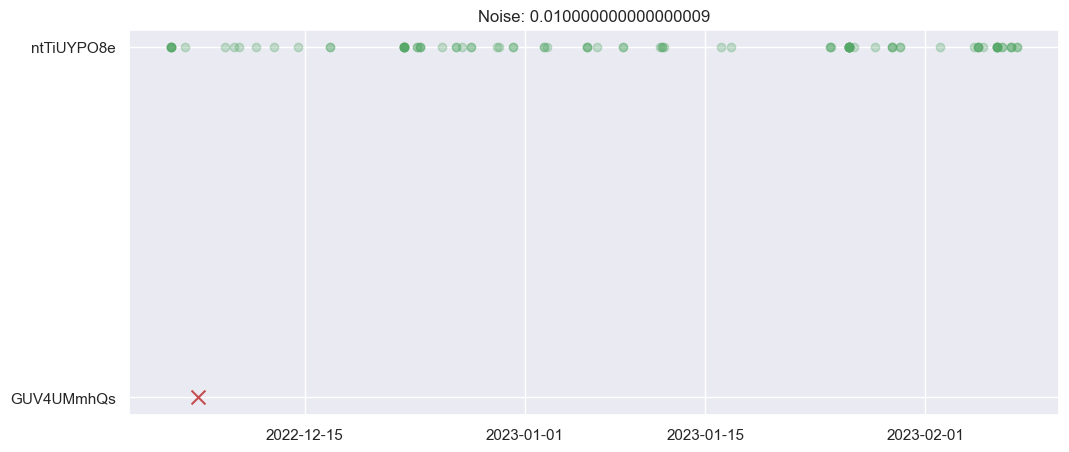

In [241]:
plt.scatter(pair_data['time'].iloc[not_inds], 
           [v for i, v in enumerate(pair_data['iiqid'].values) if i in not_inds], s=100, c='r', marker='x')
plt.scatter(pair_data.time.iloc[inds], 
            [v for i, v in enumerate(pair_data['iiqid'].values) if i in inds], c='g', marker='o', alpha=0.3)
plt.title(f"Noise: {1 - len(s) / len(pair_data)}")

In [243]:
pd.Series([1-i for i in noise_of_pairs]).describe()

count    1000.000000
mean        0.111778
std         0.123670
min         0.000000
25%         0.009501
50%         0.062500
75%         0.183732
max         0.500000
dtype: float64

In [248]:
zeros = [j for j, i in enumerate(noise_of_pairs) if i == 1]

In [279]:
found = False
limit = 1000
while not found and limit > 0:
    pair = random_pairs[random.sample(zeros, 1)[0]]
    pair_data = data[data['hh_id'].isin(pair)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
    random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
    pair_data = pair_data[pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])]
    # print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_0))/len(pair_data)}")
    # print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_1))/len(pair_data)}")
    if 0.9 > (sum(pair_data['iiqid']==random_iiqid_0))/len(pair_data) > 0.1:
        if sum(pair_data['iiqid']==random_iiqid_0) > 2 and sum(pair_data['iiqid']==random_iiqid_1) > 2:
            found = True
            s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
            not_inds = [i for i in range(len(pair_data)) if i not in inds]
    limit -= 1
print(found)
    # print(f"Noise: {1 - len(s) / len(pair_data)}")

True


Text(0.5, 1.0, 'Noise: 0.13157894736842102')

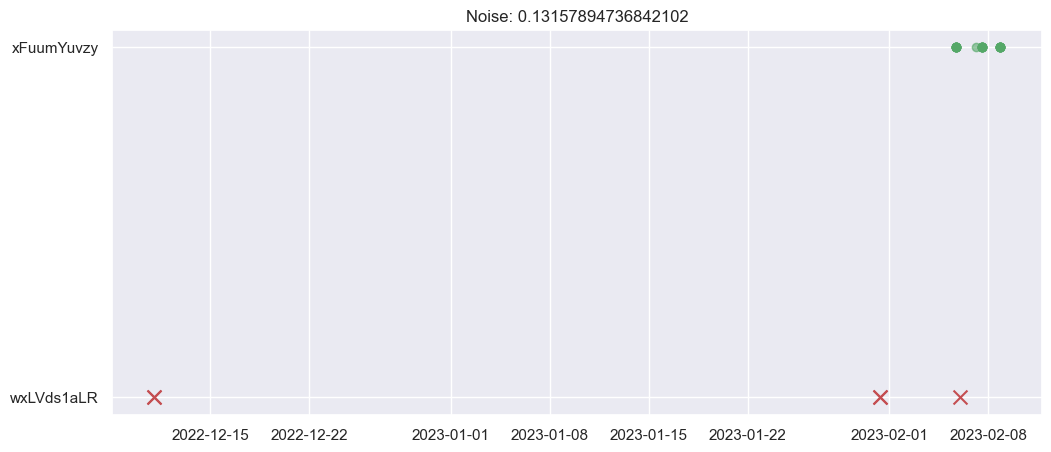

In [280]:
plt.scatter(pair_data['time'].iloc[not_inds], 
           [v for i, v in enumerate(pair_data['iiqid'].values) if i in not_inds], s=100, c='r', marker='x')
plt.scatter(pair_data.time.iloc[inds], 
            [v for i, v in enumerate(pair_data['iiqid'].values) if i in inds], c='g', marker='o', alpha=0.6)
plt.title(f"Noise: {1 - len(s) / len(pair_data)}")

### All pairs with the same constant part

In [ ]:
def overlap(cookies):
    

In [122]:
data_groups = data.groupby(constants)['hh_id'].nunique()

In [126]:
indices = data_groups[data_groups > 1].index.to_list()

In [ ]:
data[data[constants].eq(sample_specs).all(axis=1)].copy()

In [72]:
sample_data = data[data[constants].eq(sample_specs).all(axis=1)].copy()
sample_data.sort_values(by='time', inplace=True)

In [121]:
data.groupby(constants)['hh_id'].nunique()

brand  model   os       osversion  browser        advertisedbrowser    browserversion
acer   b3-a40  android  7.0        chrome mobile  Chrome Mobile        107.0.0.0         1
                                                                       108.0.0.0         2
                                                                       109.0.0.0         2
                                                                       69.0.3497.100     1
                                                  Facebook on Android  7.0               2
                                                                                        ..
zte    z982    android  7.1.1      chrome mobile  Chromium             110.0.5481.65     1
       zr01    android  10         chrome mobile  Chrome Mobile        100.0.4896.127    1
                                                                       108.0.0.0         1
                                                                       109.0.0.0         1
    